<a href="https://colab.research.google.com/github/mervenurerdogan/LungPneumoniaTez/blob/main/Ca_Pneu_Normal_ConvNext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uqq timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 7.3 MB/s eta 0:00:00


In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.3 MB/s eta 0:00:00
Mounted at /content/gdrive


In [ ]:
import timm
from fastbook import *
from fastai.vision.all import *

In [ ]:
path=Path('/content/gdrive/MyDrive/LUNGTrainTest/CA-Normal-Pneu')
path.ls()

(#4) [Path('/content/gdrive/MyDrive/LUNGTrainTest/CA-Normal-Pneu/Train'),Path('/content/gdrive/MyDrive/LUNGTrainTest/CA-Normal-Pneu/Test'),Path('/content/gdrive/MyDrive/LUNGTrainTest/CA-Normal-Pneu/CA_Pneu_Normal_VGG19_100Epoch_TrainTest.pth'),Path('/content/gdrive/MyDrive/LUNGTrainTest/CA-Normal-Pneu/CA_Pneu_Normal_resnet50_100Epoch_TrainTest.pth')]

In [ ]:

train_fnames=get_image_files(path/'Train')
all_files=get_image_files(path)

In [ ]:
dblock=DataBlock(blocks=(ImageBlock(cls=PILImage),CategoryBlock),
                 splitter=RandomSplitter(valid_pct=0.2,seed=68),
                 get_y=parent_label,
                 item_tfms=RandomResizedCrop(224),
                 batch_tfms=[*aug_transforms(size=224,
                      min_scale=0.75,
                      do_flip=True,
                      flip_vert=True,
                      max_rotate=360,
                      max_warp=0,
                      max_zoom=1.0), Contrast(p=1, draw=1.50),Normalize.from_stats(*imagenet_stats)]

)

In [ ]:
dls=dblock.dataloaders(all_files,bs=16)


In [ ]:
train_fnames=get_image_files(path/'Train')
train_df = len(train_fnames)
print(f"There are {train_df} images")

There are 5181 images


In [ ]:
test_fnames=get_image_files(path/'Test')
test_df = len(test_fnames)
print(f"There are {test_df} images")

There are 585 images


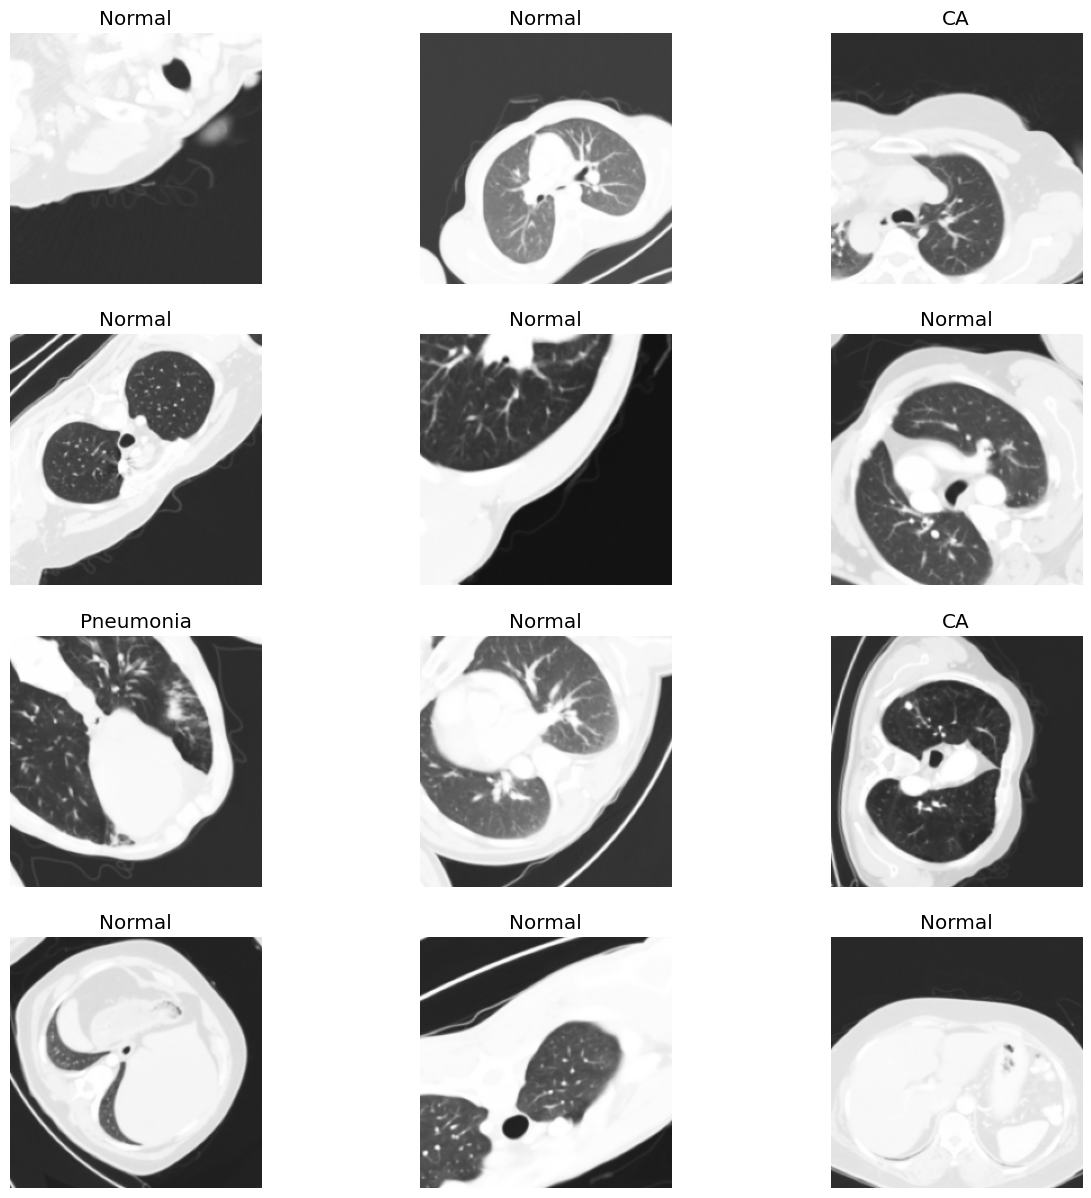

In [ ]:
dls.show_batch(max_n=12, nrows=4,figsize=(15,15))

In [ ]:
dls.vocab

['CA', 'Normal', 'Pneumonia']

In [ ]:
learn=vision_learner(dls,'convnext_tiny_in22k',metrics=accuracy)

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name convnext_tiny_in22k to current convnext_tiny.fb_in22k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/178M [00:00<?, ?B/s]

In [ ]:
print(learn.summary());

Sequential (Input shape: 16 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 96 x 56 x 56   
Conv2d                                    4704       False     
LayerNorm2d                               192        True      
Identity                                                       
Conv2d                                    4800       False     
LayerNorm                                 192        True      
____________________________________________________________________________
                     16 x 56 x 56 x 384  
Linear                                    37248      False     
GELU                                                           
Dropout                                                        
Identity                                                       
____________________________________________________________________________
                     16 x 56 x 56 x 96   
Linear                             

SuggestedLRs(valley=0.0030199517495930195)

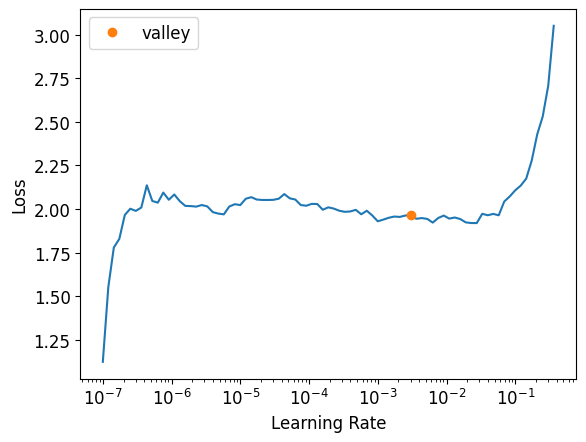

In [ ]:
learn.lr_find()


In [ ]:
learn.fine_tune(100,0.003)


epoch,train_loss,valid_loss,accuracy,time
0,1.027804,0.648635,0.740677,10:12


epoch,train_loss,valid_loss,accuracy,time
0,0.727745,0.598852,0.777103,02:01
1,0.669950,0.522021,0.796184,02:02
2,0.645664,0.523727,0.801388,02:03
3,0.571655,0.469172,0.819601,02:03
4,0.561517,0.425042,0.843886,02:03
5,0.537098,0.476811,0.815265,02:06
6,0.478937,0.397720,0.851691,02:04
7,0.465221,0.358659,0.870772,02:03
8,0.469261,0.373918,0.856028,02:04
9,0.456189,0.349935,0.869905,02:07


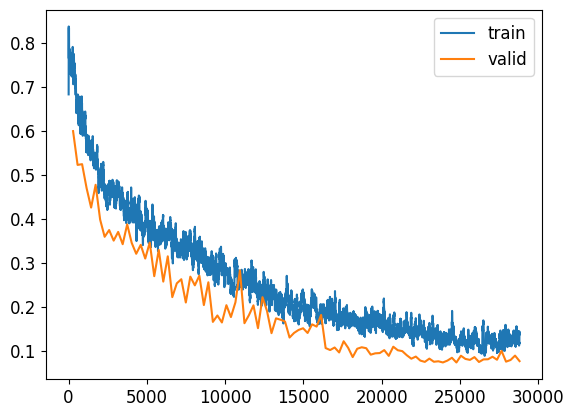

In [ ]:
learn.recorder.plot_loss()


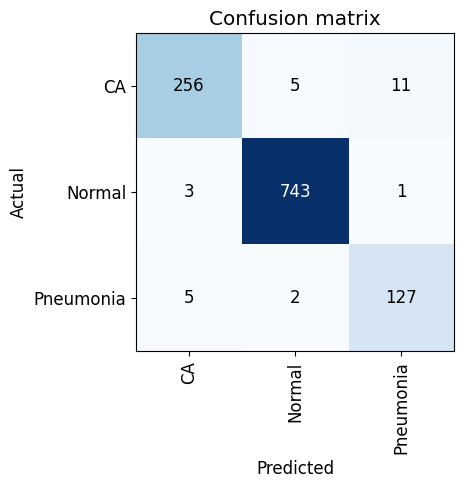

In [ ]:
interp=ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.print_classification_report()


              precision    recall  f1-score   support

          CA       0.97      0.94      0.96       272
      Normal       0.99      0.99      0.99       747
   Pneumonia       0.91      0.95      0.93       134

    accuracy                           0.98      1153
   macro avg       0.96      0.96      0.96      1153
weighted avg       0.98      0.98      0.98      1153



In [ ]:
preds, targs = learn.tta()
accuracy(preds, targs).item()

0.9861231446266174

In [ ]:
interp.most_confused()

[('CA', 'Pneumonia', 11),
 ('CA', 'Normal', 5),
 ('Pneumonia', 'CA', 5),
 ('Normal', 'CA', 3),
 ('Pneumonia', 'Normal', 2),
 ('Normal', 'Pneumonia', 1)]

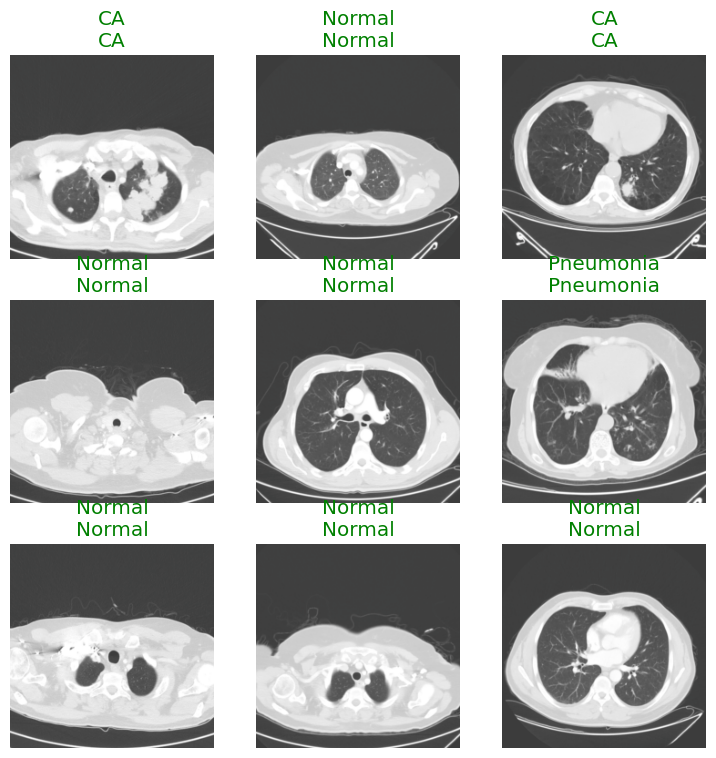

In [ ]:
learn.show_results()

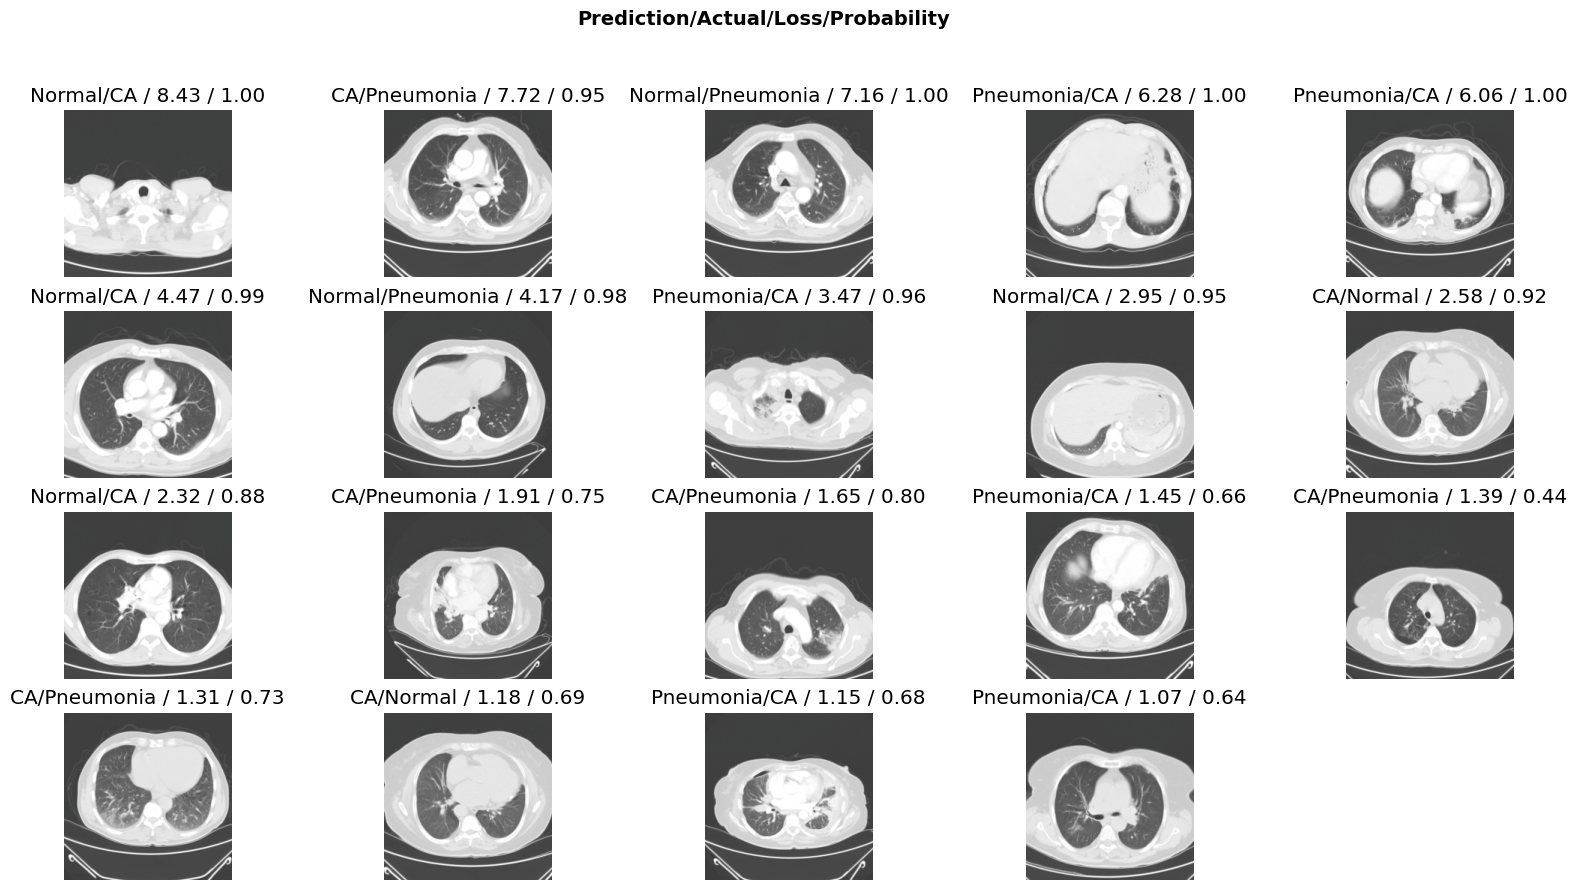

In [ ]:
interp.plot_top_losses(19, figsize=(20,10))

In [ ]:
learn.save(path/'CA_Pneu_Normal_Convnext_tiny_in22k_100Epoch_TrainTest')

Path('/content/gdrive/MyDrive/LUNGTrainTest/CA-Normal-Pneu/CA_Pneu_Normal_Convnext_tiny_in22k_100Epoch_TrainTest.pth')

In [ ]:
learn.export(path/'CA_Pneu_Normal_Convnext_tiny_in22k_100Epoch_TrainTest_Export.pkl')


In [ ]:
dblock=DataBlock(blocks=(ImageBlock(cls=PILImage),CategoryBlock),
                 splitter=GrandparentSplitter(train_name='Train',valid_name='Test'),
                 get_y=parent_label,
                 item_tfms=RandomResizedCrop(224),
                 batch_tfms=[*aug_transforms(size=224,
                      min_scale=0.75,
                      do_flip=True,
                      flip_vert=True,
                      max_rotate=360,
                      max_warp=0,
                      max_zoom=1.0), Contrast(p=1, draw=1.50),Normalize.from_stats(*imagenet_stats)]

)

In [ ]:
dls_test = dblock.dataloaders(all_files)

In [ ]:
learn1=learn=vision_learner(dls_test,'convnext_tiny_in22k',metrics=accuracy).load('/content/gdrive/MyDrive/LUNGTrainTest/CA-Normal-Pneu/CA_Pneu_Normal_Convnext_tiny_in22k_100Epoch_TrainTest')


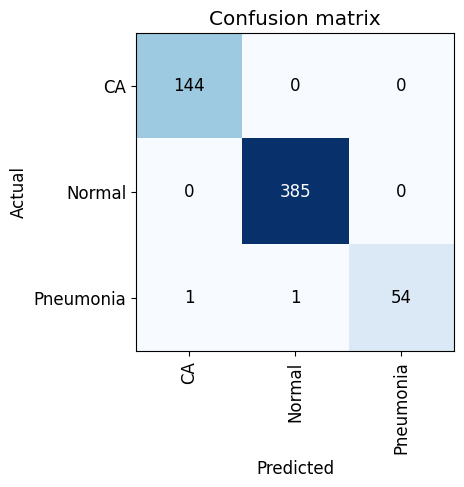

In [ ]:
interp = ClassificationInterpretation.from_learner(learn1)
interp.plot_confusion_matrix()

In [ ]:
interp.print_classification_report()

              precision    recall  f1-score   support

          CA       0.99      1.00      1.00       144
      Normal       1.00      1.00      1.00       385
   Pneumonia       1.00      0.96      0.98        56

    accuracy                           1.00       585
   macro avg       1.00      0.99      0.99       585
weighted avg       1.00      1.00      1.00       585



In [ ]:
interp.most_confused()


[('Pneumonia', 'CA', 1), ('Pneumonia', 'Normal', 1)]

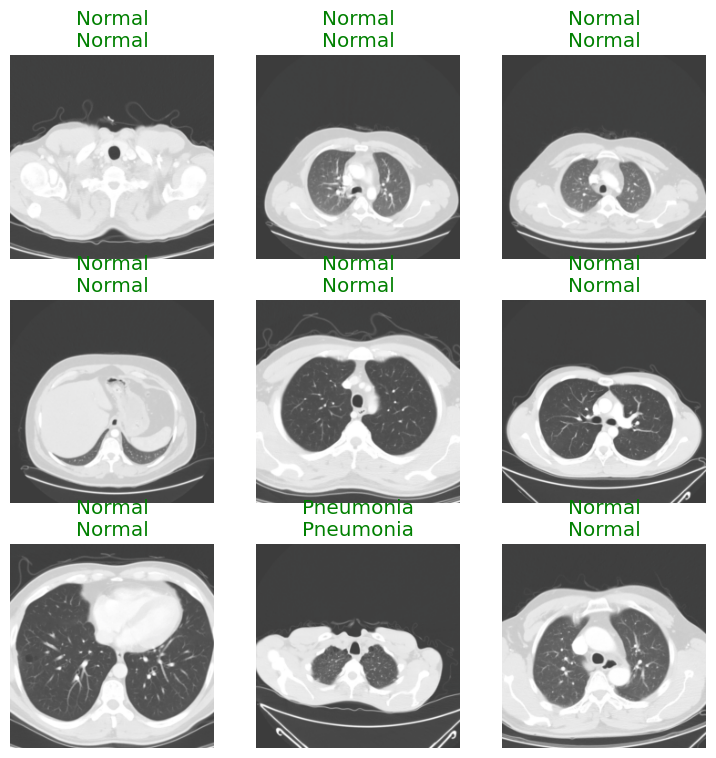

In [ ]:
learn1.show_results()

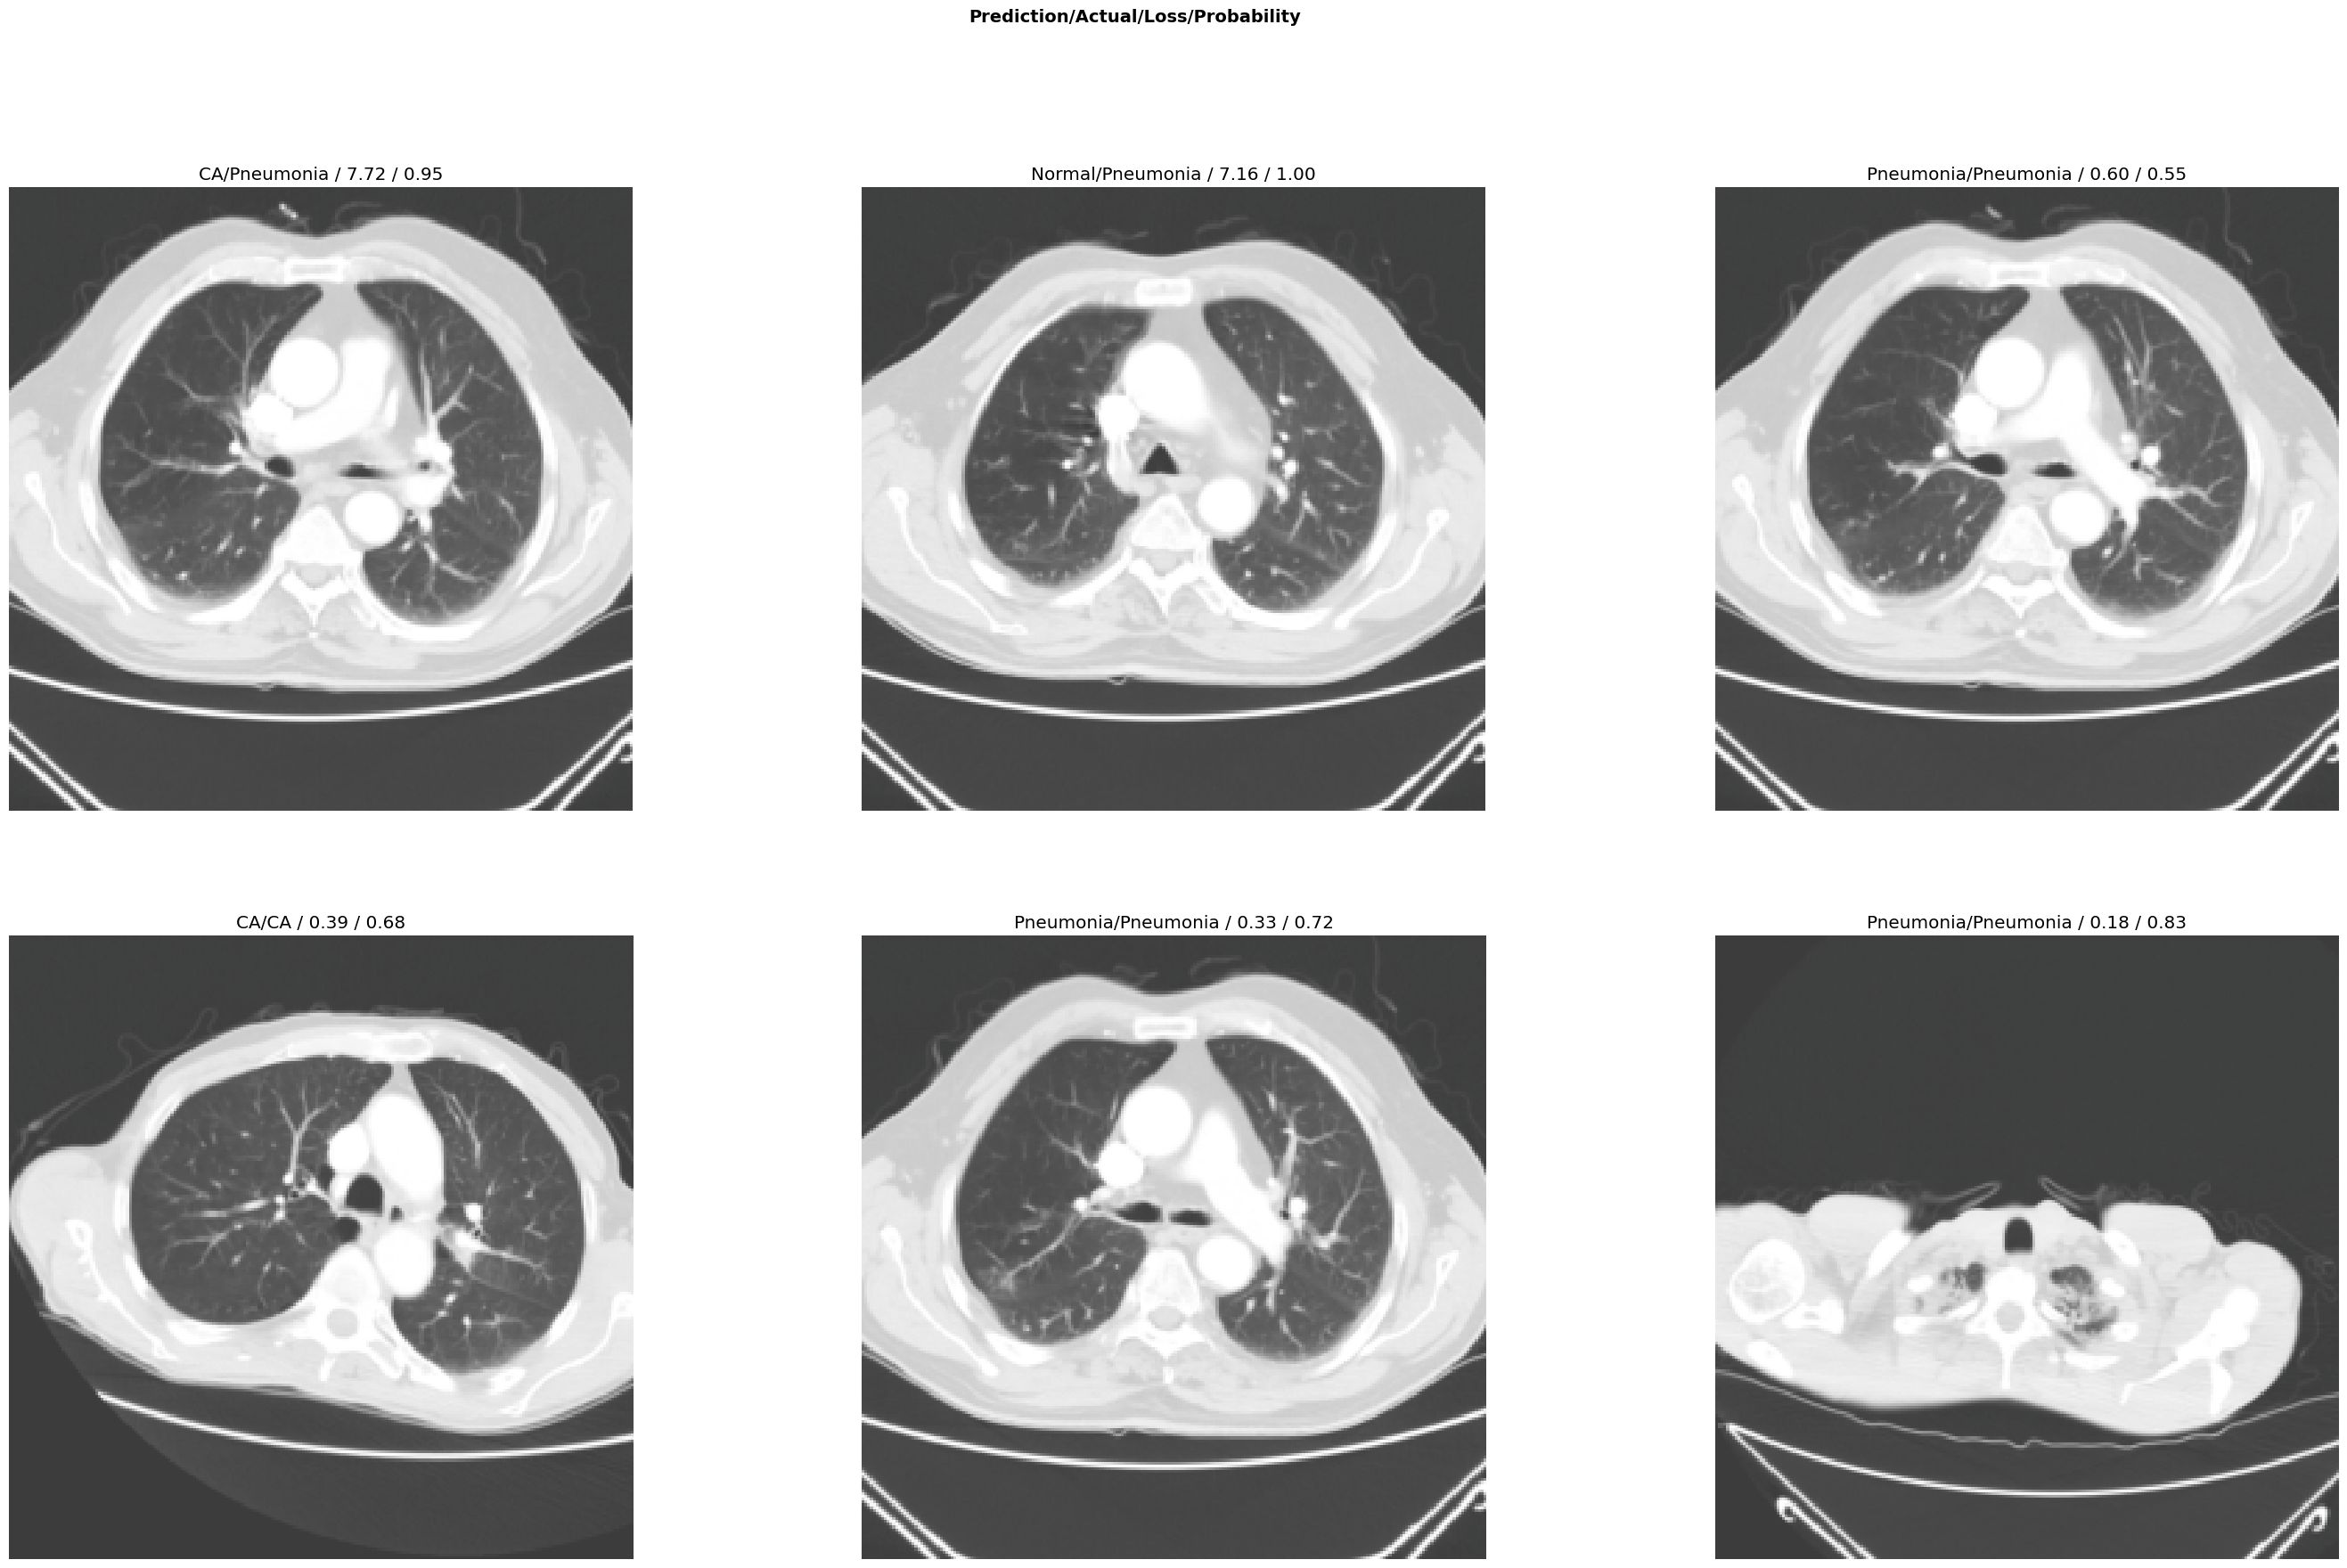

In [ ]:
interp.plot_top_losses(6, figsize=(35,20))
